# Find the central star of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 24th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

SelectRegion_HEN2_5


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [17]:
inputdir="./reduced_fitsimages"      # Do not apply background subtraction, only reduction
#inputdir="./processed_fitsimages"   # Having applied background subtraction
object_name='HEN2_5'

In [18]:
!ls reduced_fitsimages

reduced_HEN2_5_20170119_507.fits reduced_HEN2_5_20170119_516.fits
reduced_HEN2_5_20170119_508.fits reduced_HEN2_5_20170119_517.fits
reduced_HEN2_5_20170119_509.fits reduced_HEN2_5_20170119_518.fits
reduced_HEN2_5_20170119_510.fits reduced_HEN2_5_20170119_519.fits
reduced_HEN2_5_20170119_511.fits reduced_HEN2_5_20170119_520.fits
reduced_HEN2_5_20170119_512.fits reduced_HEN2_5_20170119_521.fits
reduced_HEN2_5_20170119_513.fits reduced_HEN2_5_20170119_522.fits
reduced_HEN2_5_20170119_514.fits reduced_HEN2_5_20170119_523.fits
reduced_HEN2_5_20170119_515.fits


### Output directory fot fits images

In [19]:
outputdir="./cut_fitsimages"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
print input_filelist[:5]

['reduced_HEN2_5_20170119_507.fits' 'reduced_HEN2_5_20170119_508.fits'
 'reduced_HEN2_5_20170119_509.fits' 'reduced_HEN2_5_20170119_510.fits'
 'reduced_HEN2_5_20170119_511.fits']


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [25]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
#                num_str=re.findall('^imgbkgsub_HD14943_20170117_([0-9]+).fits',file)[0] #### SELECT
                num_str=re.findall('^reduced_HEN2_5_20170119_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [26]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
print indexes_files

[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523]


In [29]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [30]:
sorted_numbers=indexes_files[sorted_indexes]

In [31]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [32]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [33]:
#sorted_files

## Build full filename
----------------------------

In [34]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [35]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [36]:
print sorted_filenames.shape

(17,)


## Acces to data of  images
----------------------------------

In [37]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [38]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header

In [39]:
all_dates,all_airmass,all_images,all_titles,all_header=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [40]:
len(all_images)

17

In [41]:
%%cython

import numpy as np
import matplotlib.pyplot as plt
import os    

def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """

    #global dir_top_images
    
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/4)+1
    

    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=2000)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16) 
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

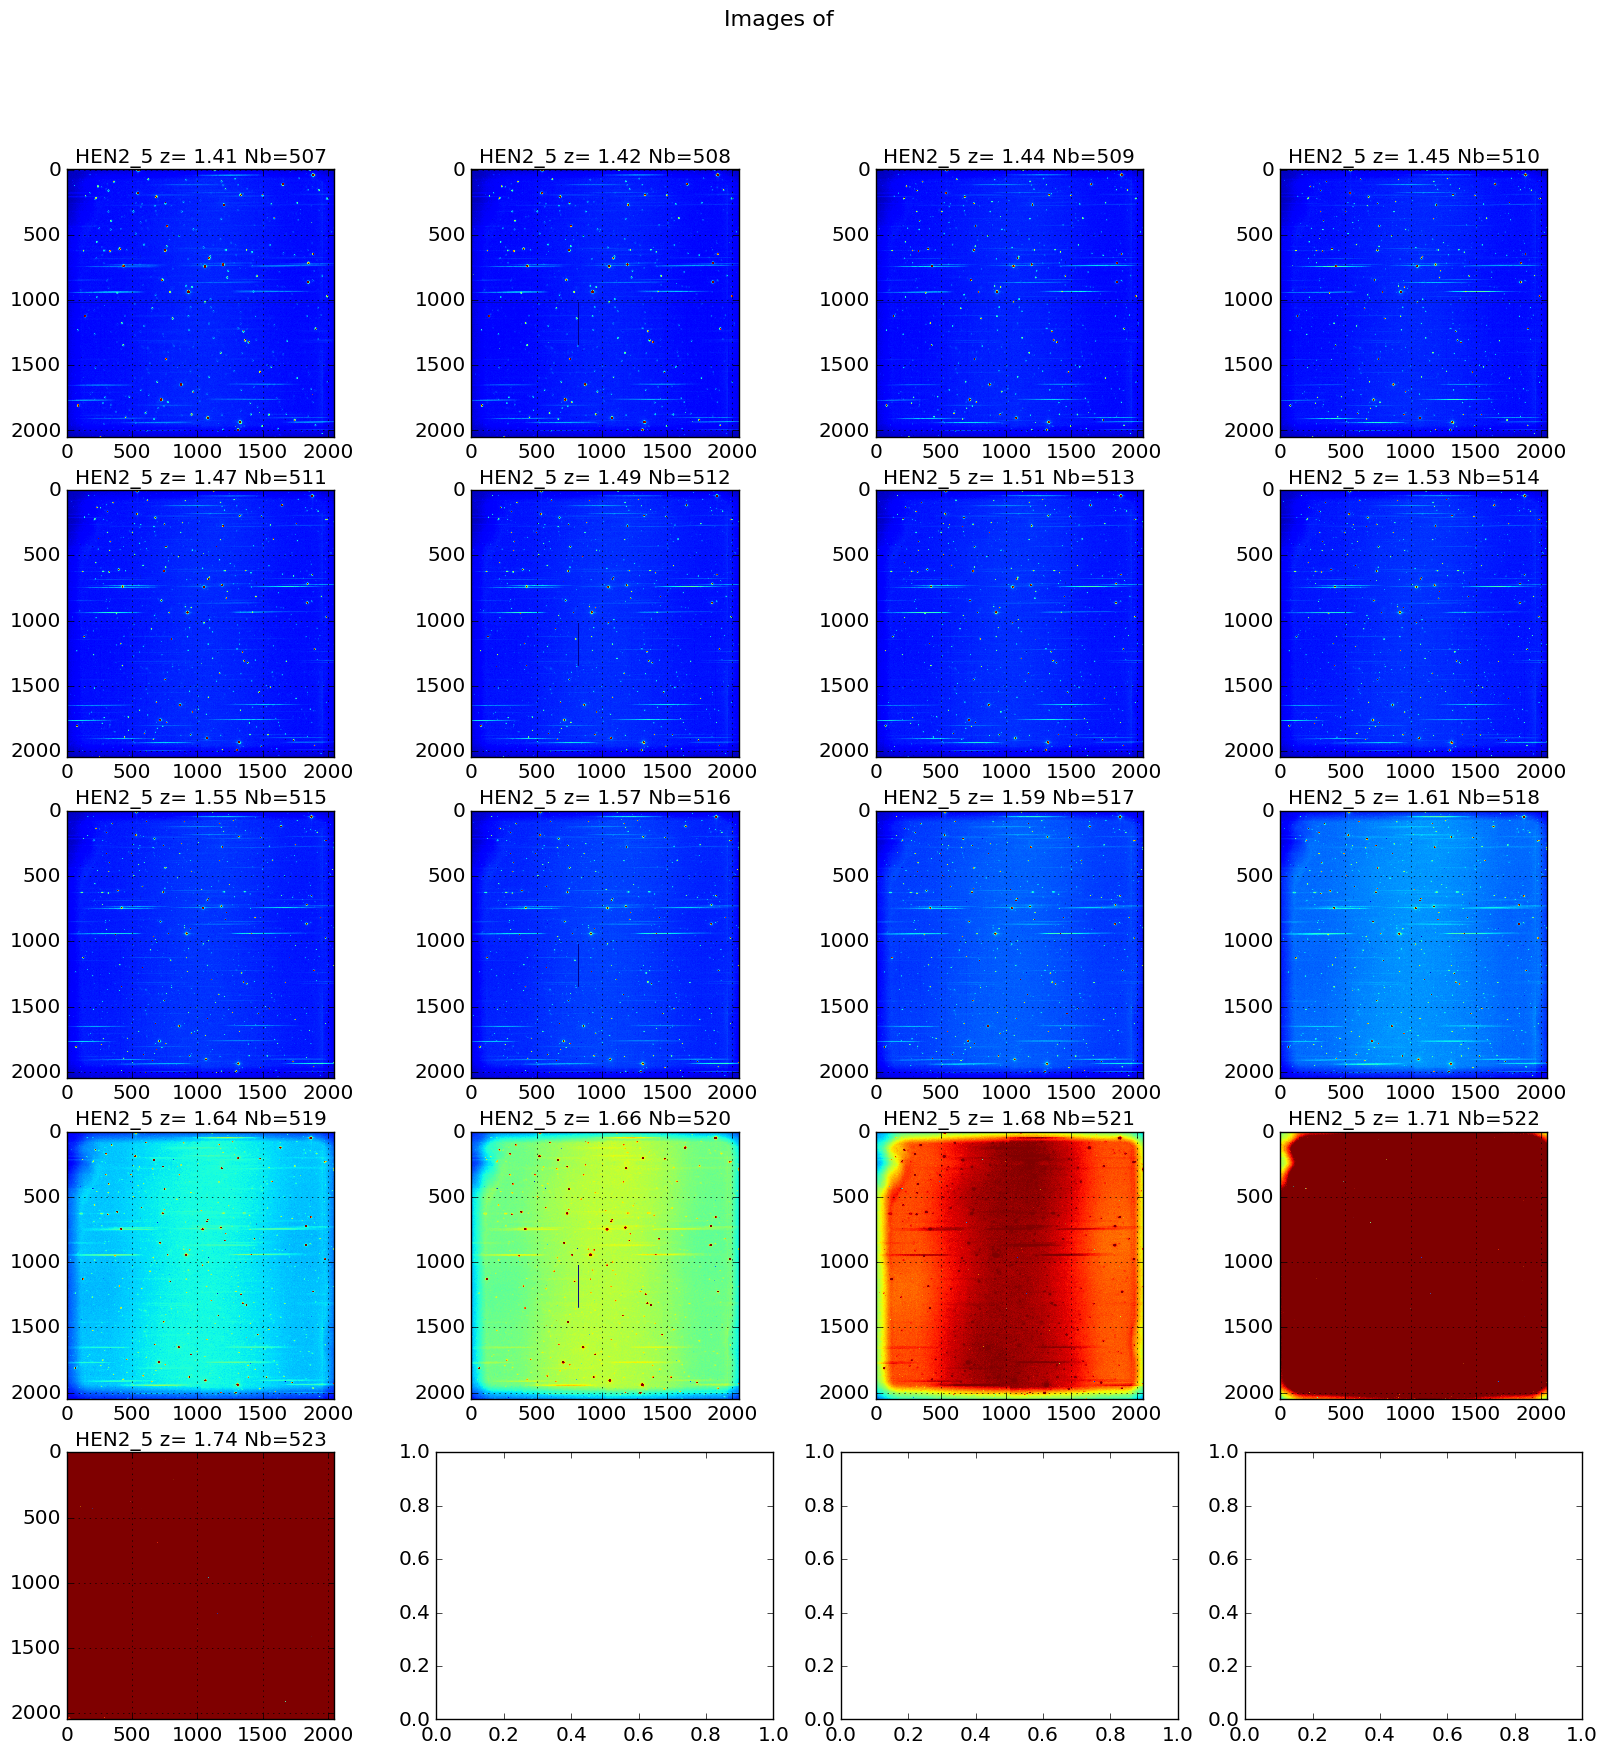

In [42]:
ShowImages(all_images,all_titles,object_name,dir_top_images)

Voilà deux images qui devraient t’aider. La zone en Y est autour de Y=685 pour l’ordre 1 (687 ordre 0, à la louche).
HEN2-5-im205 est une vue globale de l’image #205; l’autre est un zoom autour de l’ordre 1, qui encadre la zone intéressante.
J’espère que ça te sera utile. Bon courage.    Marc

In [43]:
YMIN=610
YMAX=640

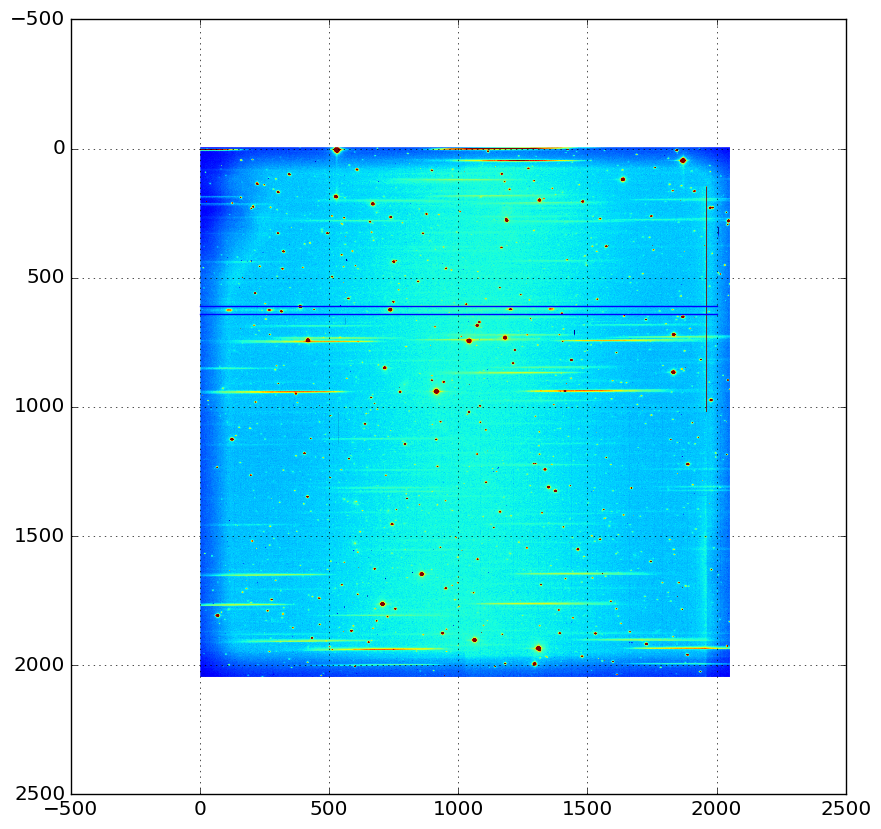

In [44]:
sel=9
plt.figure(figsize=(10,10))
plt.imshow(all_images[sel],vmin=-10,vmax=1000)
plt.plot([0,2000],[YMIN,YMIN],'b-',lw=1)
plt.plot([0,2000],[YMAX,YMAX],'b-',lw=1)
plt.grid(True)

### Cut the image
------------------

In [50]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,YMIN,YMAX,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/2)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2

        theimage=all_images[index]
        
        image_cut=theimage[YMIN:YMAX,:]
        croped_images.append(image_cut)

        im=axarr[iy,ix].imshow(image_cut,vmin=-10,vmax=5000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        #aperture.plot(color='red', lw=5.)
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

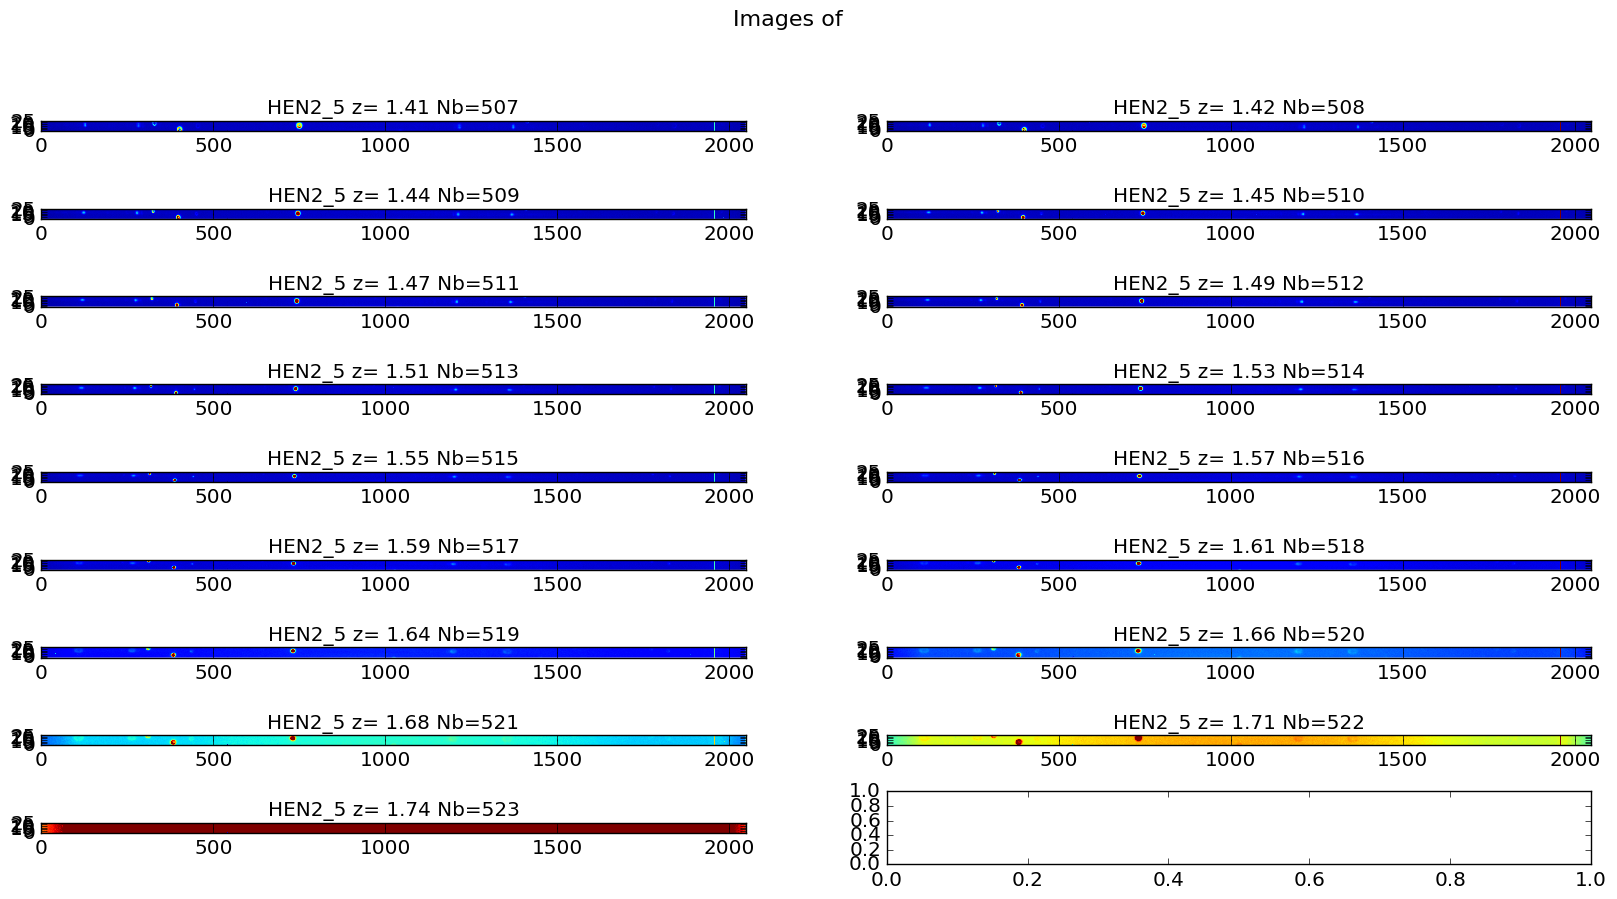

In [51]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,YMIN,YMAX,dir_top_images)

### Example of cut image
-------------------------

### prepare outputfilename

In [47]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    #short_partfilename=re.findall('^imgbkgsub_(.*)',short_infilename)  #### SELECT
    short_partfilename=re.findall('^reduced_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

### Save outputfilename

In [48]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [49]:
# !ls -l cut_fitsimages